# Modelling continuous data with Tensoflow Probability (TFP)

In this notebook you will learn how work with TFP. Kudos goes to 'Lars Bosshard' for starting the translation from python to R. 

In [1]:

#### A mixture of discrete and continuous variables ####
library(tensorflow)
library(keras)
library(MASS)
library(tensorflow)
library(keras)
library(tidyverse)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
library(tfprobability)

In [3]:



# bern_utils #####
R_START = 1-0.0001 #1.0-1E-1
L_START = 0.0001


# Creates Autoregressive masks for a given adjency matrix and hidden features
create_masks <- function(adjacency, hidden_features=c(64, 64)) {
  out_features <- nrow(adjacency)
  in_features <- ncol(adjacency)
  
  #adjacency_unique <- unique(adjacency, MARGIN = 1)
  #inverse_indices <- match(as.matrix(adjacency), as.matrix(adjacency_unique))
  
  #np.dot(adjacency.astype(int), adjacency.T.astype(int)) == adjacency.sum(axis=-1, keepdims=True).T
  d = tcrossprod(adjacency * 1L) #  "transposed cross-product", equivalent to X %*% t(X)
  precedence <-  d == matrix(rowSums(adjacency * 1L), ncol=nrow(adjacency), nrow=nrow(d), byrow = TRUE)
  
  masks <- list()
  for (i in seq_along(c(hidden_features, out_features))) {
    if (i > 1) {
      mask <- precedence[, indices, drop = FALSE]
    } else {
      mask <- adjacency
    }
    
    if (all(!mask)) {
      stop("The adjacency matrix leads to a null Jacobian.")
    }
    
    if (i <= length(hidden_features)) {
      reachable <- which(rowSums(mask) > 0)
      if (length(reachable) > 0) {
        indices <- reachable[(seq_len(hidden_features[i]) - 1) %% length(reachable) + 1]
      } else {
        indices <- integer(0)
      }
      mask <- mask[indices, , drop = FALSE]
    } 
    #else {
    #  mask <- mask[inverse_indices, , drop = FALSE]
    #}
    masks[[i]] <- mask
  }
  return(masks)
}


###### LinearMasked ####
LinearMasked(keras$layers$Layer) %py_class% {
  
  initialize <- function(units = 32, mask = NULL, bias=TRUE, name = NULL, trainable = NULL, dtype = NULL) {
    super$initialize(name = name)
    self$units <- units
    self$mask <- mask  # Add a mask parameter
    self$bias = bias
    # The additional arguments (name, trainable, dtype) are not used but are accepted to prevent errors during deserialization
  }
  
  build <- function(input_shape) {
    self$w <- self$add_weight(
      name = "w",
      shape = shape(input_shape[[2]], self$units),
      initializer = "random_normal",
      trainable = TRUE
    )
    if (self$bias) {
      self$b <- self$add_weight(
        name = "b",
        shape = shape(self$units),
        initializer = "random_normal",
        trainable = TRUE
      )
    } else{
      self$b <- NULL
    }
    
    # Handle the mask conversion if it's a dictionary (when loaded from a saved model)
    if (!is.null(self$mask)) {
      np <- import('numpy')
      if (is.list(self$mask) || "AutoTrackable" %in% class(self$mask)) {
        # Extract the mask value and dtype from the dictionary
        mask_value <- self$mask$config$value
        mask_dtype <- self$mask$config$dtype
        print("Hallo Gallo")
        mask_dtype = 'float32'
        print(mask_dtype)
        # Convert the mask value back to a numpy array
        mask_np <- np$array(mask_value, dtype = mask_dtype)
        # Convert the numpy array to a TensorFlow tensor
        self$mask <- tf$convert_to_tensor(mask_np, dtype = mask_dtype)
      } else {
        # Ensure the mask is the correct shape and convert it to a tensor
        if (!identical(dim(self$mask), dim(self$w))) {
          stop("Mask shape must match weights shape")
        }
        self$mask <- tf$convert_to_tensor(self$mask, dtype = self$w$dtype)
      }
    }
  }
  
  call <- function(inputs) {
    if (!is.null(self$mask)) {
      # Apply the mask
      masked_w <- self$w * self$mask
    } else {
      masked_w <- self$w
    }
    if(!is.null(self$b)){
      tf$matmul(inputs, masked_w) + self$b
    } else{
      tf$matmul(inputs, masked_w)
    }
  }
  
  get_config <- function() {
    config <- super$get_config()
    config$units <- self$units
    config$mask <- if (!is.null(self$mask)) tf$make_ndarray(tf$make_tensor_proto(self$mask)) else NULL
    config
  }
}




create_param_net <- function(len_param, input_layer, layer_sizes, masks, last_layer_bias=TRUE) {
  outs = list()
  for (r in 1:len_param){
    d = input_layer
    if (length(layer_sizes) > 2){ #Hidden Layers
      for (i in 2:(length(layer_sizes) - 1)) {
        d = LinearMasked(units=layer_sizes[i], mask=t(masks[[i-1]]))(d)
        #d = layer_activation(activation='relu')(d)
        d = layer_activation(activation='sigmoid')(d)
      }
    } #add output layers
    out = LinearMasked(units=layer_sizes[length(layer_sizes)], mask=t(masks[[length(layer_sizes) - 1]]),bias=last_layer_bias)(d)
    outs = append(outs,tf$expand_dims(out, axis=-1L)) #Expand last dim for concatenating
  }
  outs_c = keras$layers$concatenate(outs, axis=-1L)
}


# Creates a keras layer which takes as input (None, |x|) and returns (None, |x|, 1) which are all zero 
create_null_net <- function(input_layer) {
  output_layer <- layer_lambda(input_layer, function(x) {
    # Create a tensor of zeros with the same shape as x
    zeros_like_x <- k_zeros_like(x)
    # Add an extra dimension to match the desired output shape (None, |x|, 1)
    expanded_zeros_like_x <- k_expand_dims(zeros_like_x, -1)
    return(expanded_zeros_like_x)
  })
  return(output_layer)
}

create_param_model = function(MA, hidden_features_I = c(2,2), len_theta=30, hidden_features_CS = c(2,2)){
  
  # number of variable as input shape
  input_layer <- layer_input(shape = list(ncol(MA)))
  
  ##### Creating the Intercept Model
  if ('ci' %in% MA == TRUE) { # At least one 'ci' in model
    layer_sizes_I <- c(ncol(MA), hidden_features_I, nrow(MA))
    masks_I = create_masks(adjacency =  t(MA == 'ci'), hidden_features_I)
    h_I = create_param_net(len_param = len_theta, input_layer=input_layer, layer_sizes = layer_sizes_I, masks_I, last_layer_bias=TRUE)
    #dag_maf_plot(masks_I, layer_sizes_I)
    #model_ci = keras_model(inputs = input_layer, h_I)
  } else { # Adding simple intercepts
    layer_sizes_I = c(ncol(MA), nrow(MA))
    masks_I = list(matrix(FALSE, nrow=nrow(MA), ncol=ncol(MA)))
    h_I = create_param_net(len_param = len_theta, input_layer=input_layer, layer_sizes = layer_sizes_I, masks_I, last_layer_bias=TRUE)
    #dag_maf_plot(masks_I, layer_sizes_I)
  }
  
  ##### Creating the Complex Shift Model
  if ('cs' %in% MA == TRUE) { # At least one 'cs' in model
    layer_sizes_CS <- c(ncol(MA), hidden_features_CS, nrow(MA))
    masks_CS = create_masks(adjacency =  t(MA == 'cs'), hidden_features_CS)
    h_CS = create_param_net(len_param = 1, input_layer=input_layer, layer_sizes = layer_sizes_CS, masks_CS, last_layer_bias=FALSE)
    #dag_maf_plot(masks_CS, layer_sizes_CS)
    # model_cs = keras_model(inputs = input_layer, h_CS)
  } else { #No 'cs' term in model --> return zero
    h_CS = create_null_net(input_layer)
  }
  
  ##### Creating the Linear Shift Model
  if ('ls' %in% MA == TRUE) {
    #h_LS = keras::layer_dense(input_layer, use_bias = FALSE, units = 1L)
    layer_sizes_LS <- c(ncol(MA), nrow(MA))
    masks_LS = create_masks(adjacency =  t(MA == 'ls'), c())
    out = LinearMasked(units=layer_sizes_LS[2], mask=t(masks_LS[[1]]), bias=FALSE, name='beta')(input_layer) 
    h_LS = tf$expand_dims(out, axis=-1L)#keras$layers$concatenate(outs, axis=-1L)
    #dag_maf_plot(masks_LS, layer_sizes_LS)
    #model_ls = keras_model(inputs = input_layer, h_LS)
  } else {
    h_LS = create_null_net(input_layer)
  }
  #Keras does not work with lists (only in eager mode)
  #model = keras_model(inputs = input_layer, outputs = list(h_I, h_CS, h_LS))
  #Dimensions h_I (B,3,30) h_CS (B, 3, 1) h_LS(B, 3, 3)
  # Convention for stacking
  # 1       CS
  # 2->|X|+1 LS
  # |X|+2 --> Ende M 
  outputs_tensor = keras$layers$concatenate(list(h_CS, h_LS, h_I), axis=-1L)
  param_model = keras_model(inputs = input_layer, outputs = outputs_tensor)
  return(param_model)
}



###### to_theta3 ####
# See zuko but fixed for order 3
# Used in Loss

# ensures that theta's are increasing (theta1 left as it is, then increasing)
to_theta3 = function(theta_tilde){
  shift = tf$convert_to_tensor(log(2) * dim(theta_tilde)[[length(dim(theta_tilde))]] / 2)
  order = tf$shape(theta_tilde)[3]
  widths = tf$math$softplus(theta_tilde[,, 2L:order, drop=FALSE])
  widths = tf$concat(list(theta_tilde[,, 1L, drop=FALSE], widths), axis = -1L)
  return(tf$cumsum(widths, axis = -1L) - shift)
}

# Used in Loss

### h_dag
# returns bernstein polynomial from equation 4 (paper)
h_dag = function(t_i, theta){
  len_theta = tf$shape(theta)[3L] #TODO tied to 3er Tensors
  Be = bernstein_basis(t_i, len_theta-1L) 
  return (tf$reduce_mean(theta * Be, -1L))  
}

### h_dag_dash
h_dag_dash = function(t_i, theta){
  len_theta = tf$shape(theta)[3L] #TODO tied to 3er Tensors
  Bed = bernstein_basis(t_i, len_theta-2L) 
  dtheta = (theta[,,2:len_theta,drop=FALSE]-theta[,,1:(len_theta-1L), drop=FALSE])
  return (tf$reduce_sum(dtheta * Bed, -1L))
}


h_dag_extra = function(t_i, theta, k_min, k_max){
  DEBUG = FALSE
  t_i = (t_i - k_min)/(k_max - k_min) # Scaling
  t_i3 = tf$expand_dims(t_i, axis=-1L)
  # for t_i < 0 extrapolate with tangent at h(0)
  b0 <- tf$expand_dims(h_dag(L_START, theta),axis=-1L)
  slope0 <- tf$expand_dims(h_dag_dash(L_START, theta), axis=-1L) 
  # If t_i < 0, use a linear extrapolation
  mask0 <- tf$math$less(t_i3, L_START)
  h <- tf$where(mask0, slope0 * (t_i3 - L_START) + b0, t_i3)
  #if (DEBUG) printf('~~~ eval_h_extra  Fraction of extrapolated samples < 0 : %f \n', tf$reduce_mean(tf$cast(mask0, tf$float32)))
  
  #(for t_i > 1)
  b1 <- tf$expand_dims(h_dag(R_START, theta),axis=-1L)
  slope1 <-  tf$expand_dims(h_dag_dash(R_START, theta), axis=-1L)
  # If t_i > 1, use a linear extrapolation
  mask1 <- tf$math$greater(t_i3, R_START)
  h <- tf$where(mask1, slope1 * (t_i3 - R_START) + b1, h)
  if (DEBUG) printf('~~~ eval_h_extra  Fraction of extrapolated samples > 1 : %f \n', tf$reduce_mean(tf$cast(mask1, tf$float32)))
  
  # For values in between, use the original function
  mask <- tf$math$logical_and(tf$math$greater_equal(t_i3, L_START), tf$math$less_equal(t_i3, R_START))
  h <- tf$where(mask, tf$expand_dims(h_dag(t_i, theta), axis=-1L), h)
  # Return the mean value
  return(tf$squeeze(h))
}


# returns the shifted h() for the given t_i, with the quantiles linearly interpolated

h_dag_extra_struc = function(t_i, theta, shift, k_min, k_max){
  #Throw unsupported error
  DEBUG = FALSE
  #stop('Please check before removing')
  #k_min <- k_constant(global_min)
  #k_max <- k_constant(global_max)
  t_i = (t_i - k_min)/(k_max - k_min) # Scaling
  t_i3 = tf$expand_dims(t_i, axis=-1L)
  # if (length(t_i$shape) == 2) {
  #   t_i3 = tf$expand_dims(t_i, axis=-1L)
  # } 
  # for t_i < 0 extrapolate with tangent at h(0)
  b0 <- tf$expand_dims(h_dag(L_START, theta) + shift,axis=-1L)
  slope0 <- tf$expand_dims(h_dag_dash(L_START, theta), axis=-1L) 
  # If t_i < 0, use a linear extrapolation
  mask0 <- tf$math$less(t_i3, L_START)
  h <- tf$where(mask0, slope0 * (t_i3 - L_START) + b0, t_i3)
  #if (DEBUG) printf('~~~ eval_h_extra  Fraction of extrapolated samples < 0 : %f \n', tf$reduce_mean(tf$cast(mask0, tf$float32)))
  
  #(for t_i > 1)
  b1 <- tf$expand_dims(h_dag(R_START, theta) + shift,axis=-1L)
  slope1 <-  tf$expand_dims(h_dag_dash(R_START, theta), axis=-1L)
  # If t_i > 1, use a linear extrapolation
  mask1 <- tf$math$greater(t_i3, R_START)
  h <- tf$where(mask1, slope1 * (t_i3 - R_START) + b1, h)
  if (DEBUG) printf('~~~ eval_h_extra  Fraction of extrapolated samples > 1 : %f \n', tf$reduce_mean(tf$cast(mask1, tf$float32)))
  
  # For values in between, use the original function
  mask <- tf$math$logical_and(tf$math$greater_equal(t_i3, L_START), tf$math$less_equal(t_i3, R_START))
  h <- tf$where(mask, tf$expand_dims(h_dag(t_i, theta) + shift, axis=-1L), h)
  # Return the mean value
  return(tf$squeeze(h))
}

h_dag_dash_extra = function(t_i, theta, k_min, k_max){
  t_i = (t_i - k_min)/(k_max - k_min) # Scaling
  t_i3 = tf$expand_dims(t_i, axis=-1L)
  
  #Left extrapolation
  slope0 <- tf$expand_dims(h_dag_dash(L_START, theta), axis=-1L) # creates the slope by 
  mask0 <- tf$math$less(t_i3, L_START) 
  h_dash <- tf$where(mask0, slope0, t_i3)
  
  #Right extrapolation
  slope1 <-  tf$expand_dims(h_dag_dash(R_START, theta), axis=-1L)
  mask1 <- tf$math$greater(t_i3, R_START)
  h_dash <- tf$where(mask1, slope1, h_dash)
  
  #Interpolation
  mask <- tf$math$logical_and(tf$math$greater_equal(t_i3, L_START), tf$math$less_equal(t_i3, R_START))
  h_dash <- tf$where(mask, tf$expand_dims(h_dag_dash(t_i,theta),axis=-1L), h_dash)
  
  return (tf$squeeze(h_dash))
}


### Bernstein Basis Polynoms of order M (i.e. M+1 coefficients)
# return (B,Nodes,M+1)
bernstein_basis <- function(tensor, M) {
  # Ensure tensor is a TensorFlow tensor
  tensor <- tf$convert_to_tensor(tensor)
  dtype <- tensor$dtype
  M = tf$cast(M, dtype)
  # Expand dimensions to allow broadcasting
  tensor_expanded <- tf$expand_dims(tensor, -1L)
  # Ensuring tensor_expanded is within the range (0,1) 
  tensor_expanded = tf$clip_by_value(tensor_expanded, tf$keras$backend$epsilon(), 1 - tf$keras$backend$epsilon())
  k_values <- tf$range(M + 1L) #from 0 to M
  
  # Calculate the Bernstein basis polynomials
  log_binomial_coeff <- tf$math$lgamma(M + 1.) - 
    tf$math$lgamma(k_values + 1.) - 
    tf$math$lgamma(M - k_values + 1.)
  log_powers <- k_values * tf$math$log(tensor_expanded) + 
    (M - k_values) * tf$math$log(1 - tensor_expanded)
  log_bernstein <- log_binomial_coeff + log_powers
  
  return(tf$exp(log_bernstein))
}



#### Loss NLL

# Define the function to calculate the logistic CDF
logistic_cdf <- function(x) {
  return(tf$math$reciprocal(tf$math$add(1, tf$math$exp(-x))))
}


struct_dag_loss = function (t_i, h_params){
  #t_i = train$df_orig # (40000, 3)    # original data x1, x2, x3 for each obs
  #h_params = h_params                 # NN outputs (CS, LS, theta') for each obs
  k_min <- k_constant(global_min)
  k_max <- k_constant(global_max)
  
  # from the last dimension of h_params the first entry is h_cs1
  # the second to |X|+1 are the LS
  # the 2+|X|+1 to the end is H_I
  
  # complex shifts for each observation
  h_cs <- h_params[,,1, drop = FALSE]
  
  # linear shifts for each observation
  h_ls <- h_params[,,2, drop = FALSE]
  #LS
  h_LS = tf$squeeze(h_ls, axis=-1L) # throw away last dimension
  #CS
  h_CS = tf$squeeze(h_cs, axis=-1L)
  theta_tilde <- h_params[,,3:dim(h_params)[3], drop = FALSE]
  #Thetas for intercept (bernstein polynomials?) -> to_theta3 to make them increasing
  theta = to_theta3(theta_tilde)
  
  if (!exists('data_type')){ #Defaulting to all continuous 
    cont_dims = 1:dim(theta_tilde)[2]
    cont_ord = c()
  } else{ 
    cont_dims = which(data_type == 'c')
    cont_ord = which(data_type == 'o')
  }
  if (len_theta == -1){ 
    len_theta = dim(theta_tilde)[3]
  }
  
  NLL = 0
  ### Continiuous dimensions
  #### At least one continuous dimension exits
  if (length(cont_dims) != 0){
    
    # inputs in h_dag_extra:
    # data=(40000, 3), 
    # theta=(40000, 3, 20), k_min=(3), k_max=(3))

    # creates the value of the Bernstein at each observation
    # and current parameters: output shape=(40000, 3)
    h_I = h_dag_extra(t_i[,cont_dims, drop=FALSE], theta[,cont_dims,1:len_theta,drop=FALSE], k_min[cont_dims], k_max[cont_dims]) 
    
    # adding the intercepts and shifts: results in shape=(40000, 3)
    # basically the estimated value of the latent variable
    h = h_I + h_LS[,cont_dims, drop=FALSE] + h_CS[,cont_dims, drop=FALSE]
    
    #Compute terms for change of variable formula
    
    # log of standard logistic density at h
    log_latent_density = -h - 2 * tf$math$softplus(-h) #log of logistic density at h
    
    ## h' dh/dtarget is 0 for all shift terms
    log_hdash = tf$math$log(tf$math$abs(
      h_dag_dash_extra(t_i[,cont_dims, drop=FALSE], theta[,cont_dims,1:len_theta,drop=FALSE], k_min[cont_dims], k_max[cont_dims]))
    ) - 
      tf$math$log(k_max[cont_dims] - k_min[cont_dims])  #Chain rule! See Hathorn page 12 
    
    NLL = NLL - tf$reduce_mean(log_latent_density + log_hdash)
  }
  
  ### Ordinal dimensions
  if (length(cont_ord) != 0){
    B = tf$shape(t_i)[1]
    for (col in cont_ord){
      # col=1
      nol = tf$cast(k_max[col] - 1L, tf$int32) # Number of cut-points in respective dimension
      theta_ord = theta[,col,1:nol,drop=TRUE] # Intercept (2 values per observation if 2 cutpoints)
      
      
      h = theta_ord + h_LS[,col, drop=FALSE] + h_CS[,col, drop=FALSE]
      # putting -Inf and +Inf to the left and right of the cutpoints
      neg_inf = tf$fill(c(B,1L), -Inf)
      pos_inf = tf$fill(c(B,1L), +Inf)
      h_with_inf = tf$concat(list(neg_inf, h, pos_inf), axis=-1L)
      logistic_cdf_values = logistic_cdf(h_with_inf)
      #cdf_diffs <- tf$subtract(logistic_cdf_values[, 2:ncol(logistic_cdf_values)], logistic_cdf_values[, 1:(ncol(logistic_cdf_values) - 1)])
      cdf_diffs <- tf$subtract(logistic_cdf_values[, 2:tf$shape(logistic_cdf_values)[2]], logistic_cdf_values[, 1:(tf$shape(logistic_cdf_values)[2] - 1)])
      # Picking the observed cdf_diff entry
      class_indices <- tf$cast(t_i[, col] - 1, tf$int32)  # Convert to zero-based index
      # Create batch indices to pair with class indices
      batch_indices <- tf$range(tf$shape(class_indices)[1])
      # Combine batch_indices and class_indices into pairs of indices
      gather_indices <- tf$stack(list(batch_indices, class_indices), axis=1)
      cdf_diff_picked <- tf$gather_nd(cdf_diffs, gather_indices)
      # Gather the corresponding values from cdf_diffs
      NLL = NLL -tf$reduce_mean(tf$math$log(cdf_diff_picked))
    }
  }
  
  ### DEBUG 
  #if (sum(is.infinite(log_lik$numpy())) > 0){
  #  print("Hall")
  #}
  return (NLL)
}





########### Interventions ######
#### Helper ####
is_upper_triangular <- function(mat) {
  # Ensure it's a square matrix
  if (nrow(mat) != ncol(mat)) {
    return(FALSE)
  }
  
  # Check if elements below the diagonal are zero
  for (i in 1:nrow(mat)) {
    for (j in 1:ncol(mat)) {
      if (j < i && mat[i, j] != 0) {
        return(FALSE)
      }
      if (j == i && mat[i, j] != 0) {
        return(FALSE)
      }
    }
  }
  
  return(TRUE)
}



########## Transformations ############
check_baselinetrafo = function(h_params){
  #h_params = param_model(train$df_orig)
  k_min <- k_constant(global_min)
  k_max <- k_constant(global_max)
  
  k_min.df <- k_min$numpy()
  k_max.df <- k_max$numpy()
  
  theta_tilde <- h_params[,,3:dim(h_params)[3], drop = FALSE]
  theta = to_theta3(theta_tilde)
  length.out  = nrow(theta_tilde)
  
  # generate dataframe for x1, x2, x3 ranging from lowest to highest
  X = matrix(NA, nrow=length.out, ncol=length(k_min))
  for(i in 1:length(k_min.df)){
    X[,i] = seq(k_min.df[i], k_max.df[i], length.out = length.out)
  }
  # convert to tensor
  t_i = k_constant(X)
  
  h_I = h_dag_extra(t_i, theta, k_min, k_max) 
  return(list(h_I = h_I$numpy(), Xs=X))
} 

sample_standard_logistic <- function(shape, epsilon=1e-7) {
  uniform_samples <- tf$random$uniform(shape, minval=0, maxval=1)
  clipped_uniform_samples <- tf$clip_by_value(uniform_samples, epsilon, 1 - epsilon)
  logistic_samples <- tf$math$log(clipped_uniform_samples / (1 - clipped_uniform_samples))
  return(logistic_samples)
}




# Load the required library
library(ggplot2)
library(grid)

# Function to draw the network
dag_maf_plot <- function(layer_masks, layer_sizes) {
  max_nodes <- max(layer_sizes)
  width <- max_nodes * 100
  min_x <- 0
  max_x <- width  # Adjust max_x to include input layer
  min_y <- Inf
  max_y <- -Inf
  
  # Create a data frame to store node coordinates
  nodes <- data.frame(x = numeric(0), y = numeric(0), label = character(0))
  
  # Draw the nodes for all layers
  for (i in 1:length(layer_sizes)) {
    size <- layer_sizes[i]
    layer_top <- max_nodes / 2 - size / 2
    
    for (j in 1:size) {
      x <- (i-1) * width
      y <- layer_top + j * 100
      label <- ifelse(i == 1, paste("x_", j, sep = ""), "")  # Add labels for the first column
      nodes <- rbind(nodes, data.frame(x = x, y = y, label=label))
      max_x <- max(max_x, x)
      min_y <- min(min_y, y)
      max_y <- max(max_y, y)
    }
  }
  
  # Create a data frame to store connection coordinates
  connections <- data.frame(x_start = numeric(0), y_start = numeric(0),
                            x_end = numeric(0), y_end = numeric(0))
  
  # Draw the connections
  for (i in 1:length(layer_masks)) {
    mask <- t(layer_masks[[i]])
    input_size <- nrow(mask)
    output_size <- ncol(mask)
    
    for (j in 1:input_size) {
      for (k in 1:output_size) {
        if (mask[j, k]) {
          start_x <- (i - 1) * width
          start_y <- max_nodes / 2 - input_size / 2 + j * 100
          end_x <- i * width
          end_y <- max_nodes / 2 - output_size / 2 + k * 100
          
          connections <- rbind(connections, data.frame(x_start = start_x, y_start = start_y,
                                                       x_end = end_x, y_end = end_y))
        }
      }
    }
  }
  
  
  # Create the ggplot object
  network_plot <- ggplot() +
    geom_segment(data = connections, aes(x = x_start, y = -y_start, xend = x_end, yend = -y_end),
                 color = 'black', size = 1,
                 arrow = arrow()) +
    geom_point(data = nodes, aes(x = x, y = -y), color = 'blue', size = 8,alpha = 0.5) +
    geom_text(data = nodes, aes(x = x, y = -y, label = label), vjust = 0, hjust = 0.5) +  # Add labels
    theme_void() 
  
  return(network_plot)
}


In [5]:


## ---- Data Preparation ------

split_data <- function(data, split){
  data.dev <- sample_frac(data, split, replace = FALSE)
  data.val <- anti_join(data, data.dev) %>% suppressMessages()
  data.dev.tx <- data.dev %>% dplyr::filter(Treatment == "Y") %>% dplyr::select(-Treatment) 
  data.dev.ct <- data.dev %>% dplyr::filter(Treatment == "N") %>% dplyr::select(-Treatment) 
  data.val.tx <- data.val %>% dplyr::filter(Treatment == "Y") %>% dplyr::select(-Treatment) 
  data.val.ct <- data.val %>% dplyr::filter(Treatment == "N") %>% dplyr::select(-Treatment)
  return(list(data.dev.tx = data.dev.tx, data.dev.ct = data.dev.ct, 
              data.val.tx = data.val.tx, data.val.ct = data.val.ct, 
              data.dev = data.dev, data.val = data.val))
}

remove_NA_data <- function(data){
  data.dev.tx <- remove_missing(data$data.dev.tx)
  data.dev.ct <- remove_missing(data$data.dev.ct)
  data.val.tx <- remove_missing(data$data.val.tx)
  data.val.ct <- remove_missing(data$data.val.ct)
  data.dev <- remove_missing(data$data.dev)
  data.val <- remove_missing(data$data.val)
  return(list(data.dev.tx = data.dev.tx, data.dev.ct = data.dev.ct, 
              data.val.tx = data.val.tx, data.val.ct = data.val.ct, 
              data.dev = data.dev, data.val = data.val))
}

## ---- Models ------

logis.ITE <- function(data, p){
  variable_names <- paste0("X", 1:p)
  form <- as.formula(paste("Y ~", paste(variable_names, collapse = " + ")))
  
  fit.dev.tx <- glm(form, data = data$data.dev.tx, family = binomial(link = "logit"))
  fit.dev.ct <- glm(form, data = data$data.dev.ct, family = binomial(link = "logit"))
  
  # Predict ITE on derivation sample
  pred.data.dev <- data$data.dev %>% dplyr::select(variable_names)
  pred.dev <- predict(fit.dev.tx, newdata = pred.data.dev, type = "response") -
    predict(fit.dev.ct, newdata = pred.data.dev, type = "response")
  
  # Predict ITE on validation sample
  pred.data.val <- data$data.val %>% dplyr::select(variable_names)
  pred.val <- predict(fit.dev.tx, newdata = pred.data.val, type = "response") -
    predict(fit.dev.ct, newdata = pred.data.val, type = "response")
  
  # generate data
  data.dev.rs <- data$data.dev %>% 
    mutate(ITE = pred.dev, RS = ifelse(ITE < 0, "benefit", "harm")) %>%
    mutate(RS = as.factor(RS))
  
  data.val.rs <- data$data.val %>% 
    mutate(ITE = pred.val, RS = ifelse(ITE < 0, "benefit", "harm")) %>%
    mutate(RS = as.factor(RS))
  
  return(list(data.dev.rs = data.dev.rs, data.val.rs = data.val.rs, 
              model.dev.tx = fit.dev.tx, model.dev.ct = fit.dev.ct))
}



logis.ITE.simple <- function(data, p){
  variable_names <- paste0("X", 1:p)
  form <- as.formula(paste("Y ~ ", paste(c("Treatment", variable_names), collapse = " + ")))
  
  fit.dev <- glm(form, data = data$data.dev, family = binomial(link = "logit"))
  
  # Predict ITE on derivation sample
  pred.data.dev.N <- data$data.dev %>%
    dplyr::select(c("Treatment", variable_names)) %>%
    dplyr::mutate(Treatment = "N")
  pred.data.dev.Y <- data$data.dev %>%
    dplyr::select(c("Treatment", variable_names)) %>%
    dplyr::mutate(Treatment = "Y")
  
  pred.dev <- predict(fit.dev, newdata = pred.data.dev.Y, type = "response") -
    predict(fit.dev, newdata = pred.data.dev.N, type = "response")
  
  # Predict ITE on validation sample
  pred.data.val.N <- data$data.val%>%
    dplyr::select(c("Treatment", variable_names)) %>%
    dplyr::mutate(Treatment = "N")
  pred.data.val.Y <- data$data.val %>%
    dplyr::select(c("Treatment", variable_names)) %>%
    dplyr::mutate(Treatment = "Y")
  
  pred.val <- predict(fit.dev, newdata = pred.data.val.Y, type = "response") -
    predict(fit.dev, newdata = pred.data.val.N, type = "response")
  
  # generate data
  data.dev.rs <- data$data.dev %>% 
    mutate(ITE = pred.dev, RS = ifelse(ITE < 0, "benefit", "harm")) %>%
    mutate(RS = as.factor(RS))
  
  data.val.rs <- data$data.val %>% 
    mutate(ITE = pred.val, RS = ifelse(ITE < 0, "benefit", "harm")) %>%
    mutate(RS = as.factor(RS))
  
  return(list(data.dev.rs = data.dev.rs, data.val.rs = data.val.rs, 
              model.dev = fit.dev))
}




## ---- Calculate ATE -----
calc.ATE <- function(data){
  data <- as.data.frame(data)
  model <- glm(Y ~ Treatment, data = data, family = binomial(link = "logit"))
  ATE1 <- predict(model, newdata = data.frame(Treatment = "Y"), type = "response") - predict(model, newdata = data.frame(Treatment = "N"), type = "response")
  ATE2 <- mean(data$Y[data$Treatment == "Y"], na.rm = T) -
    mean(data$Y[data$Treatment == "N"], na.rm = T)
  
  return(data.frame(ATE1 = ATE1, ATE2 = ATE2))
}

calc.ATE.Odds <- function(data, log.odds = Treatment){
  data <- as.data.frame(data)
  model <- glm(Y ~ Treatment, data = data, family = binomial(link = "logit"))
  if (!log.odds){
    ATE.odds <- exp(coef(model)[2])
    ATE.lb <- exp(suppressMessages(confint(model)[2,1]))
    ATE.ub <- exp(suppressMessages(confint(model)[2,2]))
  } else {
    ATE.odds <- coef(model)[2]
    ATE.lb <- suppressMessages(confint(model)[2,1])
    ATE.ub <- suppressMessages(confint(model)[2,2])
  }
  return(data.frame(ATE.odds = ATE.odds, ATE.lb = ATE.lb, ATE.ub = ATE.ub, 
                    n.total = nrow(data), 
                    n.tr = sum(data$Treatment == "Y"), n.ct = sum(data$Treatment == "N")))
}

calc.ATE.RR <- function(data){
  data <- as.data.frame(data)
  model <- glm(Y ~ Treatment, data = data, family = quasipoisson(link = "log"))
  ATE.odds <- exp(coef(model)[2])
  ATE.lb <- exp(suppressMessages(confint(model)[2,1]))
  ATE.ub <- exp(suppressMessages(confint(model)[2,2]))
  return(data.frame(ATE.odds = ATE.odds, ATE.lb = ATE.lb, ATE.ub = ATE.ub, 
                    n.total = nrow(data), 
                    n.tr = sum(data$Treatment == "Y"), n.ct = sum(data$Treatment == "N")))
}




## ---- Outcome-ITE plot --------
plot_outcome_ITE <- function(data.dev.rs, data.val.rs , x_lim = c(-0.5,0.5)){
  p1 <- ggplot(data=data.dev.rs, aes(x=ITE, y=Y))+
    geom_point(aes(color=Treatment))+
    geom_smooth(aes(color=Treatment, fill=Treatment), method = "glm", method.args = list(family = "binomial"), alpha=0.5)+
    coord_cartesian(xlim=x_lim, ylim = c(0,1))+
    ylab("Outcome")+xlab("ITE")+
    scale_color_manual(values=c("N" = "orange", "Y" = "#36648B"), name="Treatment") +
    scale_fill_manual(values = c("N" = "orange", "Y" = "#36648B"), name="Treatment") +
    theme_minimal()+
    theme(
      panel.grid.major = element_blank(),  # Removes major grid lines
      panel.grid.minor = element_blank(),  # Removes minor grid lines
      panel.background = element_blank(),  # Removes panel background
      plot.background = element_blank(),    # Removes plot background (outside the plot)
      text = element_text(size = 14),
      axis.line = element_line(color = "black"),
      axis.ticks = element_line(color = "black")
    )
  
  p2 <- ggplot(data=data.val.rs, aes(x=ITE, y=Y))+
    geom_point(aes(color=Treatment))+
    geom_smooth(aes(color=Treatment, fill=Treatment), method = "glm", method.args = list(family = "binomial"))+
    coord_cartesian(xlim=x_lim, ylim = c(0,1))+
    ylab("Outcome")+xlab("ITE")+
    scale_color_manual(values=c("N" = "orange", "Y" = "#36648B"), name="Treatment") +
    scale_fill_manual(values = c("N" = "orange", "Y" = "#36648B"), name="Treatment") +
    theme_minimal()+
    theme(
      panel.grid.major = element_blank(),  # Removes major grid lines
      panel.grid.minor = element_blank(),  # Removes minor grid lines
      panel.background = element_blank(),  # Removes panel background
      plot.background = element_blank(),    # Removes plot background (outside the plot)
      text = element_text(size = 14),
      axis.line = element_line(color = "black"),
      axis.ticks = element_line(color = "black")
    )
  
  result <- ggarrange(p1, p2, 
                      labels = c("a) Training Data", "b) Test Data"),
                      label.x = 0, 
                      label.y = 1.04,
                      hjust = 0,
                      vjust = 1,
                      ncol = 1, nrow = 2, align = "v",
                      common.legend = T)
  
  return(result)
}

## ---- ITE density plot --------
plot_ITE_density <- function(test.results, true.data = simulated_full_data){
  result <- ggplot()+
    geom_density(aes(x = test.results$data.dev.rs$ITE, fill = "ITE.dev", color = "ITE.dev"), alpha = 0.5, linewidth=1) +
    geom_density(aes(x = test.results$data.val.rs$ITE, fill = "ITE.val", color = "ITE.val"), alpha = 0.5, linewidth=1) +
    geom_density(aes(x = true.data$ITE_true, fill = "ITE.true", color = "ITE.true"), alpha = 0.1, linewidth=1) +
    #  geom_vline(aes(xintercept = mean(test.results$data.dev.rs$ITE)), 
    #             color = "orange", linetype = "dashed") +
    #  geom_vline(aes(xintercept = mean(test.results$data.val.rs$ITE)), 
    #             color = "#36648B", linetype = "dashed") +
    geom_vline(aes(xintercept = 0), color = "black", linetype = "dashed", linewidth=1) +
    xlab("Individualized Treatment Effect") +
    ylab("Density") +
    scale_color_manual(name = "Group", 
                       labels = c("ITE.dev" = "Training Data", "ITE.val" = "Test Data", "ITE.true" = "True Data"), 
                       values = c("ITE.dev"= "orange", "ITE.val" = "#36648B", "ITE.true"= "lightgreen")) +
    scale_fill_manual(name = "Group", 
                      labels = c("ITE.dev" = "Training Data", "ITE.val" = "Test Data", "ITE.true" = "True Data"), 
                      values = c("ITE.dev"= "orange", "ITE.val" = "#36648B", "ITE.true"= "lightgreen")) +
    theme_minimal()+
    theme(
      legend.position.inside = c(1, 1),
      legend.justification = c("right", "top"),
      legend.box.just = "right",
      panel.grid.major = element_blank(),  # Removes major grid lines
      panel.grid.minor = element_blank(),  # Removes minor grid lines
      panel.background = element_blank(),  # Removes panel background
      plot.background = element_blank(),    # Removes plot background (outside the plot)
      text = element_text(size = 14),
      axis.line = element_line(color = "black"),
      axis.ticks = element_line(color = "black")
    )
  return(result)
}


## ---- ITE Density Plot by Treatment and Control Groups --------
plot_ITE_density_tx_ct <- function(data = test.results$data.dev.rs){
  result <- ggplot(data = data) +
    geom_density(aes(x = ITE, fill = Treatment, color = Treatment), alpha = 0.5, linewidth=1) +
    geom_vline(aes(xintercept = 0), color = "black", linetype = "dashed", linewidth=1) +
    xlab("Individualized Treatment Effect") +
    ylab("Density") +
    scale_color_manual(name = "Group", 
                       labels = c("Y" = "Treatment", "N" = "Control"), 
                       values = c("orange", "#36648B")) +
    scale_fill_manual(name = "Group",
                      labels = c("Y" = "Treatment", "N" = "Control"), 
                      values = c("orange", "#36648B")) +
    theme_minimal()+
    theme(
      legend.position.inside = c(1, 1),
      legend.justification = c("right", "top"),
      legend.box.just = "right",
      panel.grid.major = element_blank(),  # Removes major grid lines
      panel.grid.minor = element_blank(),  # Removes minor grid lines
      panel.background = element_blank(),  # Removes panel background
      plot.background = element_blank(),    # Removes plot background (outside the plot)
      text = element_text(size = 14),
      axis.line = element_line(color = "black"),
      axis.ticks = element_line(color = "black")
    )
  
  return(result)
}



## ---- ATE-ITE Visualization by groups for derivation and validation data ----------
plot_ATE_ITE_in_group <- function(dev.data = data.dev.rs, val.data = data.val.rs, train.data.name = train_data_name, test.data.name = test_data_name, log.odds = T, ylb=0, yub=2){
  data <- rbind(dev.data %>% mutate(sample = "derivation"), val.data %>%  mutate(sample = "validation"))
  result <- ggplot(data, aes(x = ITE.Group, y = ATE.odds)) +
    geom_line(aes(group = sample, color = sample), linewidth = 1, 
              position = position_dodge(width = 0.2)) +
    geom_point(aes(color = sample), size = 1.5, 
               position = position_dodge(width = 0.2)) +
    geom_errorbar(aes(ymin = ATE.lb, ymax = ATE.ub, color = sample), width = 0.2,
                  position = position_dodge(width = 0.2))+
    geom_hline(yintercept = ifelse(log.odds, 0, 1), linetype = "dashed", color = "black") +
    scale_color_manual(name = "Group",
                       labels = c("derivation" = train.data.name, "validation" = test.data.name),
                       values = c("orange", "#36648B"))+
    scale_x_discrete(guide = guide_axis(n.dodge = 2))+
    ylim(ylb,yub)+
    xlab("ITE Group")+
    ylab(ifelse(log.odds, "ATE in Log Odds Ratio", "ATE in Odds Ratio"))+
    theme_minimal()+
    theme(
      legend.position.inside = c(0.9, 0.9),
      legend.justification = c("right", "top"),
      legend.box.just = "right",
      panel.grid.major = element_blank(),  # Removes major grid lines
      panel.grid.minor = element_blank(),  # Removes minor grid lines
      panel.background = element_blank(),  # Removes panel background
      plot.background = element_blank(),
      text = element_text(size = 14),
      axis.line = element_line(color = "black"),
      axis.ticks = element_line(color = "black")
    )
  
  return(result)
}

# ------------ New loss funciton for tram DAG with binary treatment



struct_dag_loss_ITE = function (t_i, h_params, binary_treatment = TRUE){
  # binary_treatment = TRUE means that we amend the loss for the first variable. 
  # only used for ITE see below in ordinal loss calculation
  #t_i = train$df_orig # (40000, 3)    # original data x1, x2, x3 for each obs
  # t_i = dgp_data$df_orig_train
  #h_params = h_params                 # NN outputs (CS, LS, theta') for each obs
  k_min <- k_constant(global_min)
  k_max <- k_constant(global_max)
  
  # from the last dimension of h_params the first entry is h_cs1
  # the second to |X|+1 are the LS
  # the 2+|X|+1 to the end is H_I
  
  # complex shifts for each observation
  h_cs <- h_params[,,1, drop = FALSE]
  
  # linear shifts for each observation
  h_ls <- h_params[,,2, drop = FALSE]
  #LS
  h_LS = tf$squeeze(h_ls, axis=-1L) # throw away last dimension
  #CS
  h_CS = tf$squeeze(h_cs, axis=-1L)
  theta_tilde <- h_params[,,3:dim(h_params)[3], drop = FALSE]
  #Thetas for intercept (bernstein polynomials?) -> to_theta3 to make them increasing
  theta = to_theta3(theta_tilde)
  
  if (!exists('data_type')){ #Defaulting to all continuous 
    cont_dims = 1:dim(theta_tilde)[2]
    cont_ord = c()
  } else{ 
    cont_dims = which(data_type == 'c')
    cont_ord = which(data_type == 'o')
  }
  if (len_theta == -1){ 
    len_theta = dim(theta_tilde)[3]
  }
  
  NLL = 0
  ### Continiuous dimensions
  #### At least one continuous dimension exits
  if (length(cont_dims) != 0){
    
    # inputs in h_dag_extra:
    # data=(40000, 3), 
    # theta=(40000, 3, 20), k_min=(3), k_max=(3))
    
    # creates the value of the Bernstein at each observation
    # and current parameters: output shape=(40000, 3)
    h_I = h_dag_extra(t_i[,cont_dims, drop=FALSE], theta[,cont_dims,1:len_theta,drop=FALSE], k_min[cont_dims], k_max[cont_dims]) 
    
    # adding the intercepts and shifts: results in shape=(40000, 3)
    # basically the estimated value of the latent variable
    h = h_I + h_LS[,cont_dims, drop=FALSE] + h_CS[,cont_dims, drop=FALSE]
    
    #Compute terms for change of variable formula
    
    # log of standard logistic density at h
    log_latent_density = -h - 2 * tf$math$softplus(-h) #log of logistic density at h
    
    ## h' dh/dtarget is 0 for all shift terms
    log_hdash = tf$math$log(tf$math$abs(
      h_dag_dash_extra(t_i[,cont_dims, drop=FALSE], theta[,cont_dims,1:len_theta,drop=FALSE], k_min[cont_dims], k_max[cont_dims]))
    ) - 
      tf$math$log(k_max[cont_dims] - k_min[cont_dims])  #Chain rule! See Hathorn page 12 
    
    NLL = NLL - tf$reduce_mean(log_latent_density + log_hdash)
  }
  
  ### Ordinal dimensions
  if (length(cont_ord) != 0){
    B = tf$shape(t_i)[1]
    for (col in cont_ord){
      # col=1
      
      if (binary_treatment == TRUE & col==1){
        nol = tf$cast(k_max[col], tf$int32)
      } else {
        nol = tf$cast(k_max[col] - 1L, tf$int32) # Number of cut-points in respective dimension
      }
      theta_ord = theta[,col,1:nol,drop=TRUE] # Intercept (2 values per observation if 2 cutpoints)
      
      
      h = theta_ord + h_LS[,col, drop=FALSE] + h_CS[,col, drop=FALSE]
      # putting -Inf and +Inf to the left and right of the cutpoints
      neg_inf = tf$fill(c(B,1L), -Inf)
      pos_inf = tf$fill(c(B,1L), +Inf)
      h_with_inf = tf$concat(list(neg_inf, h, pos_inf), axis=-1L)
      logistic_cdf_values = logistic_cdf(h_with_inf)
      #cdf_diffs <- tf$subtract(logistic_cdf_values[, 2:ncol(logistic_cdf_values)], logistic_cdf_values[, 1:(ncol(logistic_cdf_values) - 1)])
      cdf_diffs <- tf$subtract(logistic_cdf_values[, 2:tf$shape(logistic_cdf_values)[2]], logistic_cdf_values[, 1:(tf$shape(logistic_cdf_values)[2] - 1)])
      # Picking the observed cdf_diff entry
      
      if (binary_treatment == TRUE & col==1){
        class_indices <- tf$cast(t_i[, col], tf$int32)  # already zero based index
      } else {
        class_indices <- tf$cast(t_i[, col] - 1, tf$int32)  # Convert to zero-based index
      }
      
      # Create batch indices to pair with class indices
      batch_indices <- tf$range(tf$shape(class_indices)[1])
      # Combine batch_indices and class_indices into pairs of indices
      gather_indices <- tf$stack(list(batch_indices, class_indices), axis=1)
      cdf_diff_picked <- tf$gather_nd(cdf_diffs, gather_indices)
      # Gather the corresponding values from cdf_diffs
      NLL = NLL -tf$reduce_mean(tf$math$log(cdf_diff_picked))
    }
  }
  
  ### DEBUG 
  #if (sum(is.infinite(log_lik$numpy())) > 0){
  #  print("Hall")
  #}
  return (NLL)
}





In [6]:
#### Saving the current version of the script into runtime
DIR = 'runs/TRAM_DAG_ITE_simulation_single_model/run'
if (!dir.exists(DIR)) {
  dir.create(DIR, recursive = TRUE)
}
# Copy this file to the directory DIR
file.copy('/TRAM_DAG_ITE_simulation_single_model.R', file.path(DIR, 'TRAM_DAG_ITE_simulation_single_model.R'), overwrite=TRUE)



[1] FALSE

In [7]:
args <- c(3, 'cs')
F32 <- as.numeric(args[1])
M32 <- args[2]
print(paste("FS:", F32, "M32:", M32))

[1] "FS: 3 M32: cs"


In [8]:

len_theta = 20 # Number of coefficients of the Bernstein polynomials
hidden_features_I = c(2,5,5,2) 
hidden_features_CS = c(2,5,5,2) #c(4,8,8,4)# c(2,5,5,2)

if (F32 == 1){
  FUN_NAME = 'DPGLinear'
  f <- function(x) -0.3 * x
} else if (F32 == 2){
  f = function(x) 2 * x**3 + x
  FUN_NAME = 'DPG2x3+x'
} else if (F32 == 3){
  f = function(x) 0.5*exp(x)
  FUN_NAME = 'DPG0.5exp'
}

if (M32 == 'ls') {
  MA =  matrix(c(
    0, 0, 'ls', 
    0,    0, 'ls', 
    0,    0,   0), nrow = 3, ncol = 3, byrow = TRUE)
  MODEL_NAME = 'ModelLS'
} else{
  MA =  matrix(c(
    0, 'ls', 'ls', 
    0,    0, 'cs', 
    0,    0,   0), nrow = 3, ncol = 3, byrow = TRUE)
  MODEL_NAME = 'ModelCS'
}

MA =  matrix(c(
  0,   0,  0, 'cs',
  0,   0,  0, 'cs',
  0,   0,  0, 'ls',
  0,   0,  0,   0), nrow = 4, ncol = 4, byrow = TRUE)
MODEL_NAME = 'ModelCS'
# MA =  matrix(c(
#   0,   0,  0, 'ci', 
#   0,   0,  0, 'ci', 
#   0,   0,  0, 'ls',
#   0,   0,  0,   0), nrow = 4, ncol = 4, byrow = TRUE)
# MODEL_NAME = 'ModelCS'

MA =  matrix(c(
  0,   0,  0, 'ci',
  0,   0,  0, 'ci',
  0,   0,  0, 'ci',
  0,   0,  0,   0), nrow = 4, ncol = 4, byrow = TRUE)
MODEL_NAME = 'ModelCS'

MA

FUN_NAME = 'x1_ordinal_12_'
# FUN_NAME = 'x1_ordinal_12_CI_'
# fn = 'triangle_mixed_DGPLinear_ModelLinear.h5'
# fn = 'triangle_mixed_DGPSin_ModelCS.h5'
fn = file.path(DIR, paste0(FUN_NAME, '_', MODEL_NAME))
print(paste0("Starting experiment ", fn))






###############################################################################
# ITE in a simple RCT
###############################################################################



##### DGP ########
dgp <- function(n_obs=10000, doX=c(NA, NA, NA, NA), SEED=123) {
  #n_obs = 1e5 n_obs = 10
  set.seed(SEED)
  
  # Data simulation
  
  ## Case 1: continuous random variables
  
  # Define sample size
  n <- n_obs
  
  # Generate random binary treatment T
  Tr <- rbinom(n, size = 1, prob = 0.5)
  
  p <- 2  # number of variables 
  
  # Define the mean vector (all zeros for simplicity)
  mu <- rep(0, p)  # Mean vector of length p
  
  # Define the covariance matrix (compound symmetric for simplicity)
  rho <- 0.1  # Correlation coefficient
  Sigma <- matrix(rho, nrow = p, ncol = p)  # Start with all elements as rho
  diag(Sigma) <- 1  # Set diagonal elements to 1 (variances)
  
  # Generate n samples from the multivariate normal distribution
  data <- MASS::mvrnorm(n, mu = mu, Sigma = Sigma)
  colnames(data) <- paste0("X", 1:p)
  
  
  # Define coefficients for the logistic model
  beta_0 <- runif(1, min=-1, max=1)             # Intercept
  beta_t <- runif(1, min=-0.5, max=0.5)             # Coefficient for treatment
  beta_X <- runif(p, min=-1, max=1)          # Coefficients for covariates
  beta_TX <- runif(1, min=-0.5, max=0.5)          # Coefficient for interaction terms
  # beta_TX <- runif(p, min=-0.5, max=0.5)          # Coefficient for interaction terms
  
  # Calculate the linear predictor (logit)
  logit_Y <- beta_0 + beta_t * Tr + data %*% beta_X + (data[,1] * beta_TX) * Tr
  
  # logit_Y <- beta_0 + beta_t * Tr + data %*% beta_X + (data %*% beta_TX) * Tr
  
  # Convert logit to probability of outcome
  Y_prob <- plogis(logit_Y)
  
  # Generate binary outcome Y based on the probability
  Y <- rbinom(n, size = 1, prob = Y_prob)
  
  # Potential outcome for treated and untreated
  Y1 <- plogis(beta_0 + beta_t + data %*% beta_X + data[,1] * beta_TX)
  # Y1 <- plogis(beta_0 + beta_t + data %*% beta_X + data %*% beta_TX)
  Y0 <- plogis(beta_0 + data %*% beta_X)
  
  # Calculate the individual treatment effect
  ITE_true <- Y1 - Y0
  
  
  # Combine all variables into a single data frame
  simulated_full_data <- data.frame(ID = 1:n, Y=Y, Treatment=Tr, data, Y1, Y0, ITE_true, Y_prob)
  
  # Data for testing ITE models
  simulated_data <- data.frame(ID =1:n, Y=Y, Treatment=Tr, Tr=Tr, data, ITE_true = ITE_true, Y_prob=Y_prob) %>% 
    # add Treatment variable Tr=Treatment
    
    
    mutate(Treatment = ifelse(Treatment==1,"Y", "N")) %>% 
    mutate(Treatment = factor(Treatment, levels = c("N", "Y")))
  
  
  set.seed(12345)
  test.data <- split_data(simulated_data, 2/3)
  test.compl.data <- remove_NA_data(test.data)
  
  
  # for two-model structure we only need the 2 patient specific variables (no Tr)
  A <- matrix(c(0, 0, 0, 1, 
                0, 0, 0, 1,
                0, 0, 0, 1,
                0, 0, 0, 0), nrow = 4, ncol = 4, byrow = TRUE)
  
  # Full dataset
  dat.orig =  data.frame(x1 = simulated_full_data$Treatment, 
                         x2 = simulated_full_data$X1, 
                         x3 = simulated_full_data$X2, 
                         x4 = simulated_full_data$Y)
  dat_temp <- as.matrix(dat.orig)
  # dat_temp[,4] <- dat_temp[,4] + 1
  dat_temp[,c(1,4)] <- dat_temp[,c(1,4)] + 1
  dat.tf = tf$constant(as.matrix(dat_temp), dtype = 'float32')
  
  # train dataset
  dat.train <- data.frame(x1 = test.compl.data$data.dev$Tr, 
                          x2 = test.compl.data$data.dev$X1, 
                          x3 = test.compl.data$data.dev$X2, 
                          x4 = test.compl.data$data.dev$Y)
  dat_temp <- as.matrix(dat.train)
  # dat_temp[,4] <- dat_temp[,4] + 1
  dat_temp[,c(1,4)] <- dat_temp[,c(1,4)] + 1
  dat.train.tf = tf$constant(as.matrix(dat_temp), dtype = 'float32')
 
  dat.test <- data.frame(x1 = test.compl.data$data.val$Tr, 
                         x2 = test.compl.data$data.val$X1, 
                         x3 = test.compl.data$data.val$X2, 
                         x4 = test.compl.data$data.val$Y)
  dat_temp <- as.matrix(dat.test)
  # dat_temp[,4] <- dat_temp[,4] + 1
  dat_temp[,c(1,4)] <- dat_temp[,c(1,4)] + 1
  dat.test.tf = tf$constant(as.matrix(dat_temp), dtype = 'float32')

  
  q1 = c(1, 2)
  q2 = quantile(dat.orig[,2], probs = c(0.05, 0.95))
  q3 = quantile(dat.orig[,3], probs = c(0.05, 0.95))
  q4 = c(1, 2) #No Quantiles for ordinal data
  # q1 = quantile(dat.orig[,2], probs = c(0.05, 0.95)) 
  # q2 = quantile(dat.orig[,3], probs = c(0.05, 0.95))
  # q3 = c(0, 1) #No Quantiles for ordinal data
  
  
  return(list(
    df_orig=dat.tf, 
    df_R = dat.orig,
    min =  tf$reduce_min(dat.tf, axis=0L),
    max =  tf$reduce_max(dat.tf, axis=0L),
    min = tf$constant(c(q1[1], q2[1], q3[1], q4[1]), dtype = 'float32'),
    max = tf$constant(c(q1[2], q2[2], q3[2], q4[2]), dtype = 'float32'),

    # min = tf$constant(c(q1[1], q2[1], q3[1]), dtype = 'float32'),
    # max = tf$constant(c(q1[2], q2[2], q3[2]), dtype = 'float32'),
    type = c('o', 'c', 'c', 'o'),
    A=A,
    
    #train
    df_R_train = dat.train,
    df_orig_train = dat.train.tf,
    
    
    # df_orig_train_ct = dat.train.ct.tf,
    # df_R_train_ct = dat.train.ct,
    # 
    # df_orig_train_tx = dat.train.tx.tf,
    # df_R_train_tx = dat.train.tx,
    
    #test
    df_R_test = dat.test,
    df_orig_test = dat.test.tf,
    
    # df_orig_test_ct = dat.test.ct.tf,
    # df_R_test_ct = dat.test.ct,
    # 
    # df_orig_test_tx = dat.test.tx.tf,
    # df_R_test_tx = dat.test.tx,
    # 
    #full
    simulated_full_data = simulated_full_data,
    simulated_data = simulated_data,
    test.compl.data = test.compl.data,
    dgp_params = list(
      beta_0 = beta_0,
      beta_t = beta_t,
      beta_X = beta_X,
      beta_TX = beta_TX
    )
  ))
} 

### Attention: Treatment variable X1 is binary coded {0,1} and not Ordinal
### I will not model the distribution for X1, but only use X1 as preditor in 
### the model for Y
n_obs <- 10000

dgp_data = dgp(n_obs)

dgp_data$df_orig_test

0,0,0,ci
0,0,0,ci
0,0,0,ci
0,0,0,0


[1] "Starting experiment runs/TRAM_DAG_ITE_simulation_single_model/run/x1_ordinal_12__ModelCS"


tf.Tensor(
[[ 1.         -0.6808454   1.177925    1.        ]
 [ 2.          1.4238819  -0.57150066  2.        ]
 [ 2.         -0.87162155 -0.02401168  1.        ]
 ...
 [ 1.         -1.1109979  -0.00519127  2.        ]
 [ 1.         -1.1208917   0.39233494  1.        ]
 [ 2.         -1.152233   -1.1852524   2.        ]], shape=(3333, 4), dtype=float32)

'data.frame':	10000 obs. of  8 variables:
 $ ID       : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Y        : int  1 0 1 0 0 0 1 0 1 0 ...
 $ Treatment: Factor w/ 2 levels "N","Y": 1 2 1 2 2 1 2 2 2 1 ...
 $ Tr       : int  0 1 0 1 1 0 1 1 1 0 ...
 $ X1       : num  0.542 1.225 -0.273 0.446 0.264 ...
 $ X2       : num  -1.275 0.448 -1.428 1.751 1.095 ...
 $ ITE_true : num  0.012869 0.033685 -0.028078 0.008273 0.000326 ...
 $ Y_prob   : num  0.285 0.215 0.424 0.281 0.307 ...


[1] -0.01813717

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(variable_names)

  # Now:
  data %>% select(all_of(variable_names))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


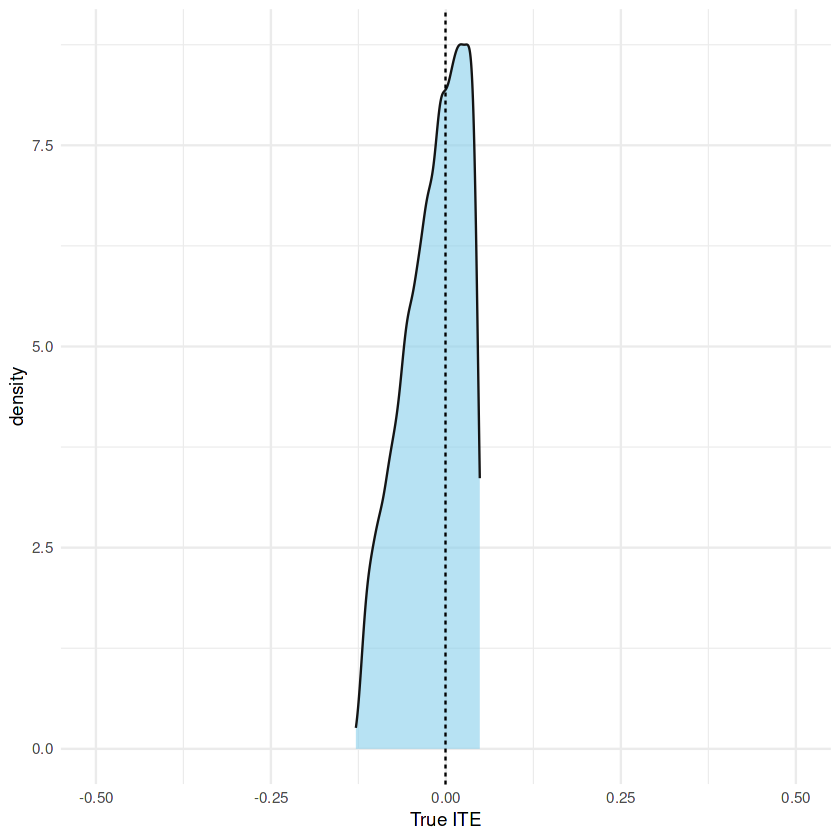

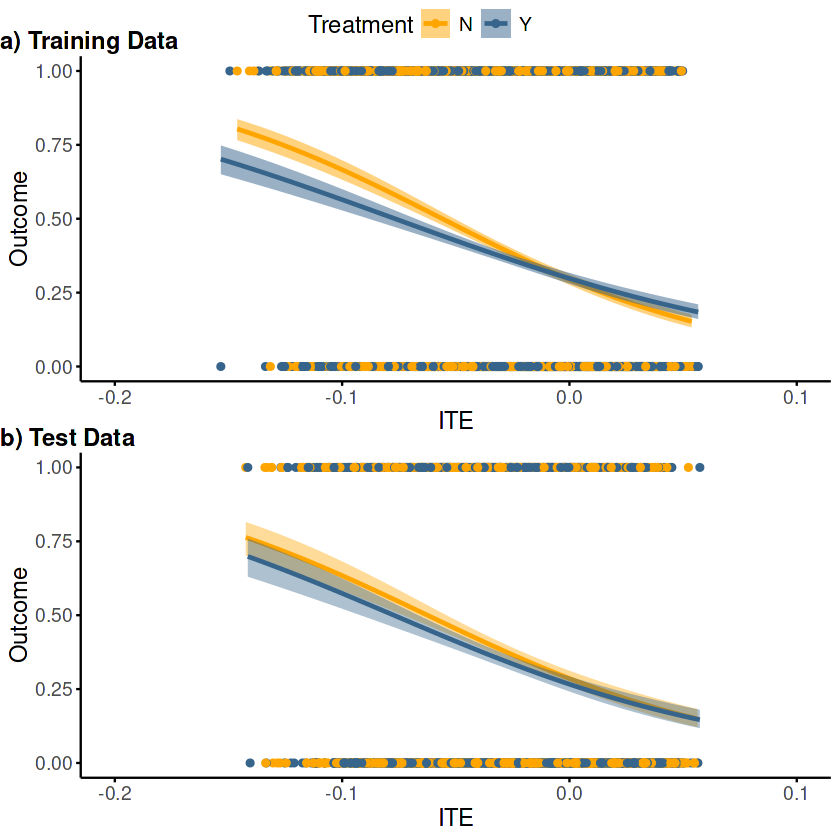

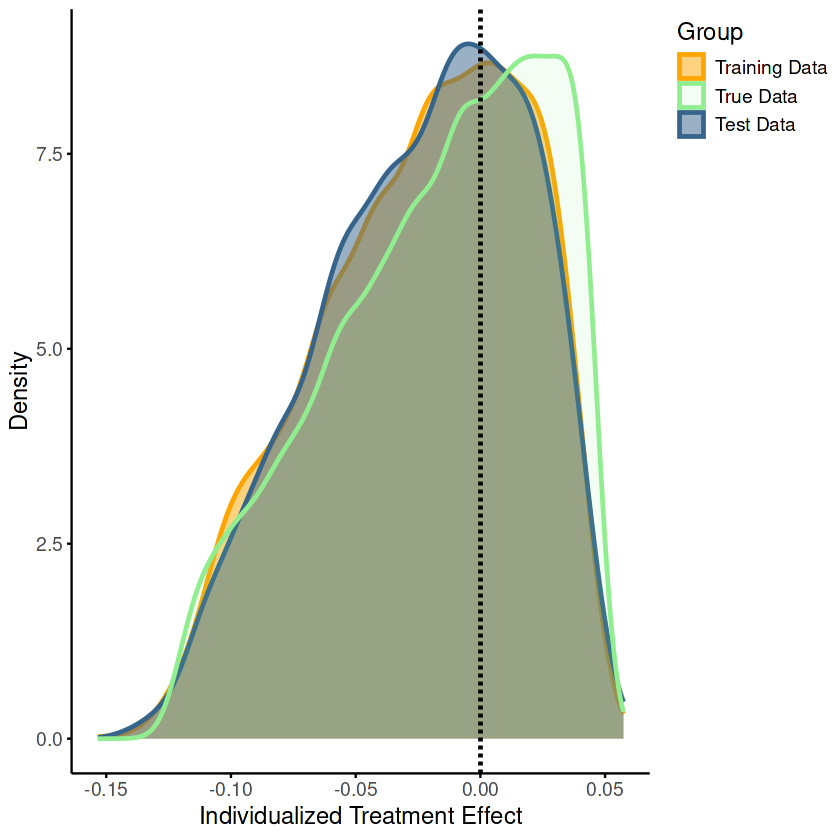

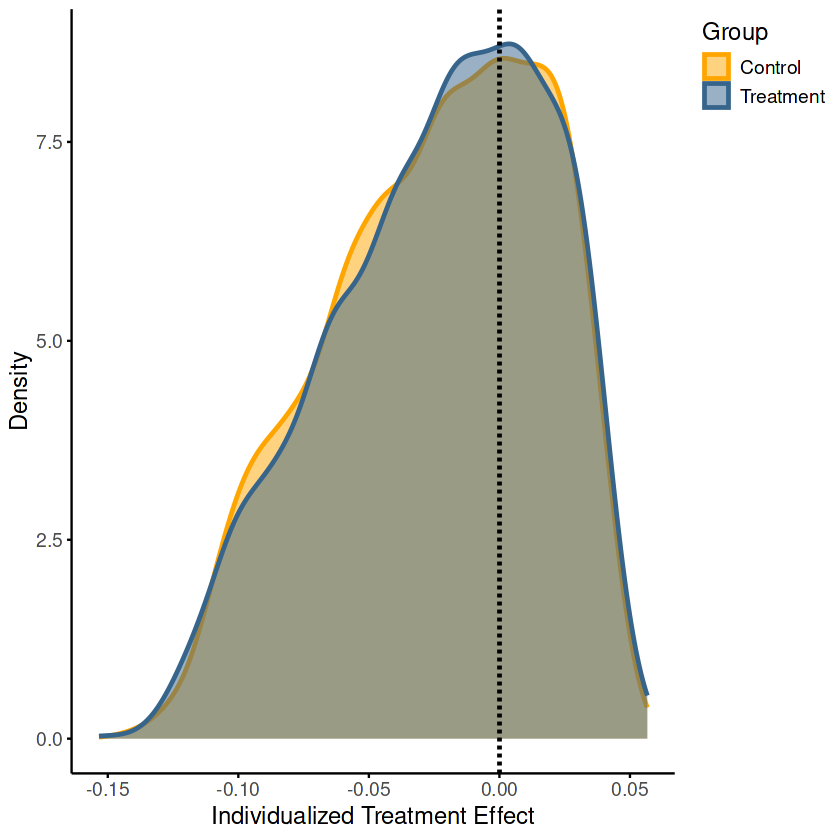

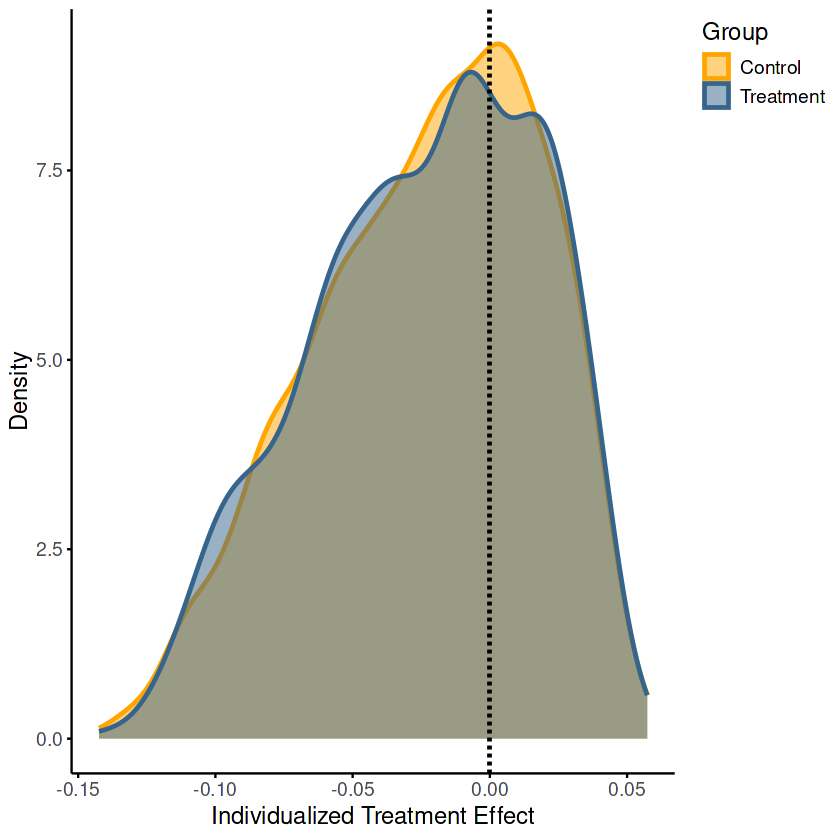

[1] 0.0100112

[1] 0.01004817

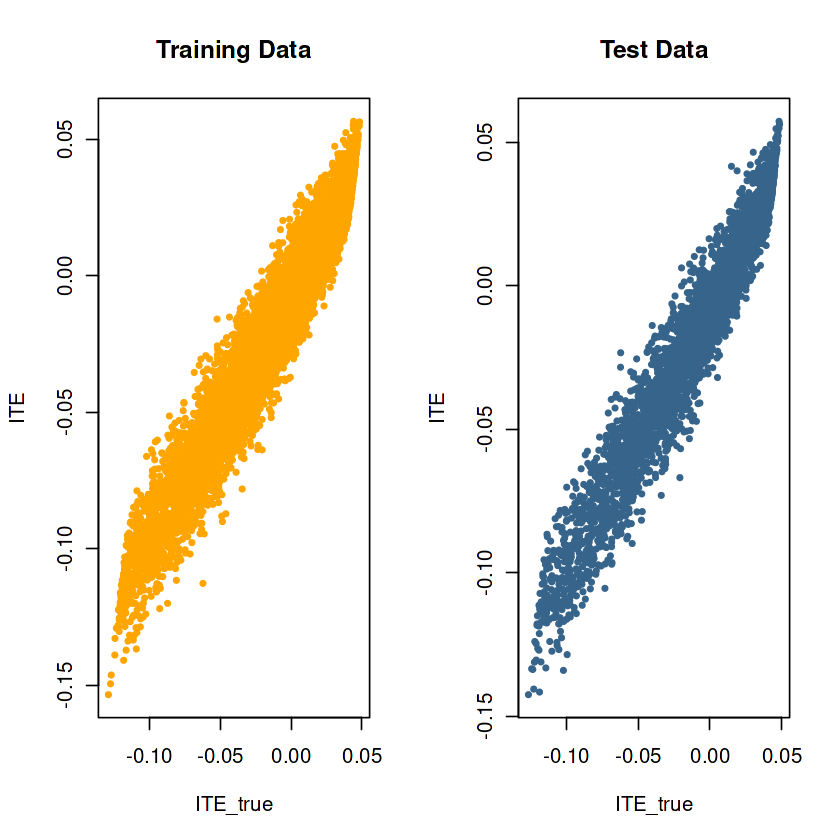

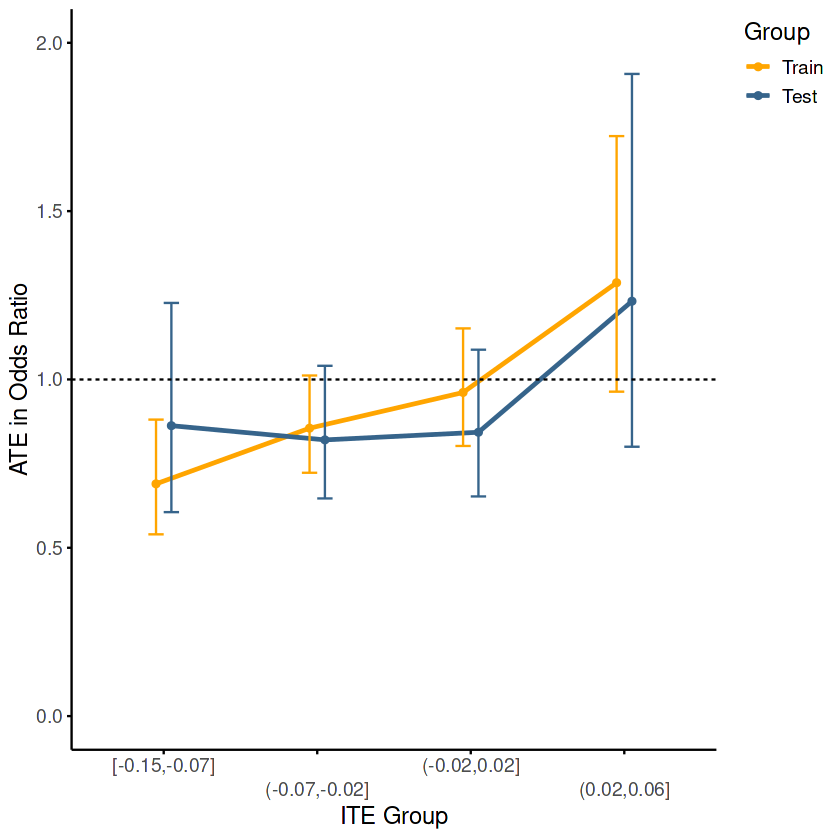

In [9]:
#################################################
# Analysis as Holly T-learner
#################################################

dgp_data$simulated_full_data %>% ggplot(aes(x=ITE_true)) +
  geom_density(color="gray8",fill="skyblue",alpha=.6) + 
  theme_minimal() + 
  xlab("True ITE") + 
  geom_vline(xintercept = 0, linetype="dashed") + coord_cartesian(xlim = c(-.5,.5))

str(dgp_data$simulated_data)

# average treatment effects
mean(dgp_data$simulated_full_data$ITE_true)

# Calculate ITE with logistic T-learner
test.results <- logis.ITE(dgp_data$test.compl.data , p=2)


data.dev.rs = test.results[["data.dev.rs"]] %>%  as.data.frame()
data.val.rs = test.results[["data.val.rs"]] %>%  as.data.frame()

library(ggpubr)
plot_outcome_ITE(data.dev.rs = data.dev.rs, data.val.rs = data.val.rs, x_lim = c(-0.2,0.1))


plot_ITE_density(test.results = test.results, true.data = dgp_data$simulated_full_data)


plot_ITE_density_tx_ct(data = data.dev.rs)
plot_ITE_density_tx_ct(data = data.val.rs)

par(mfrow=c(1,2))
plot(ITE ~ ITE_true, data = data.dev.rs, col = "orange", pch = 19, cex = 0.5
     , main = "Training Data")
plot(ITE ~ ITE_true, data = data.val.rs, col = "#36648B", pch = 19, cex = 0.5
     , main = "Test Data")

# compare estimated ITE and true ITE
mean(abs(data.dev.rs$ITE_true - data.dev.rs$ITE))
mean(abs(data.val.rs$ITE_true - data.val.rs$ITE))


breaks <- c(-0.15, -0.07, -0.02, 0.02, 0.06)
log.odds <- F
data.dev.grouped.ATE <- data.dev.rs %>% 
  mutate(ITE.Group = cut(ITE, breaks = breaks, include.lowest = T)) %>%
  dplyr::filter(!is.na(ITE.Group)) %>%
  group_by(ITE.Group) %>% 
  group_modify(~ calc.ATE.Odds(.x, log.odds = log.odds)) %>% ungroup()
data.val.grouped.ATE <- data.val.rs %>% 
  mutate(ITE.Group = cut(ITE, breaks = breaks, include.lowest = T)) %>%
  dplyr::filter(!is.na(ITE.Group)) %>%
  group_by(ITE.Group) %>%
  group_modify(~ calc.ATE.Odds(.x, log.odds = log.odds)) %>% ungroup() 

plot_ATE_ITE_in_group(dev.data = data.dev.grouped.ATE, val.data = data.val.grouped.ATE, 
                      log.odds = log.odds, ylb = 0, yub = 2,
                      train.data.name = "Train", test.data.name = "Test")





# save results for later
test.results.glm <- logis.ITE(dgp_data$test.compl.data , p=2)


data.dev.rs.glm = test.results[["data.dev.rs"]] %>%  as.data.frame()
data.val.rs.glm = test.results[["data.val.rs"]] %>%  as.data.frame()




In [10]:

#################################################
# fit TRAM-DAG wit CS for T:X1
#################################################

(global_min = dgp_data$min)
(global_max = dgp_data$max)
data_type = dgp_data$type

len_theta_max = len_theta
for (i in 1:nrow(MA)){ #Maximum number of coefficients (BS and Levels - 1 for the ordinal)
  if (dgp_data$type[i] == 'o'){
    len_theta_max = max(len_theta_max, nlevels(dgp_data$df_R[,i]) - 1)
  }
}



##### Train on control group ####

param_model = create_param_model(MA, hidden_features_I=hidden_features_I, len_theta=len_theta, hidden_features_CS=hidden_features_CS)
optimizer = optimizer_adam(learning_rate = 0.0005)
param_model$compile(optimizer, loss=struct_dag_loss)

h_params <- param_model(dgp_data$df_orig_train)

param_model$evaluate(x = dgp_data$df_orig_train, y=dgp_data$df_orig_train, batch_size = 7L)
#summary(param_model)

tf.Tensor([ 1.        -3.3805144 -3.5427825  1.       ], shape=(4), dtype=float32)

tf.Tensor([2.        3.5192282 4.0783577 2.       ], shape=(4), dtype=float32)

Warning message in force(if_any_TRUE):
“Indexing tensors are passed as-is to python, no index offsetting or R to python translation is performed. Selected options for one_based and inclusive_stop are ignored and treated as FALSE. To silence this warning, set options(tensorflow.extract.warn_tensors_passed_asis = FALSE)”


[1] 11.61017

In [ ]:
summary(param_model)

In [ ]:

##### Training ####
num_epochs <- 1000
# fnh5 = paste0(fn, '_E', num_epochs, '.h5')
# fnRdata = paste0(fn, '_E', num_epochs, '.RData')

fnh5 = paste0(fn, '_E', num_epochs, 'train_control.h5')
fnRdata = paste0(fn, '_E', num_epochs, 'train_control.RData')
if (file.exists(fnh5)){
  param_model$load_weights(fnh5)
  load(fnRdata) #Loading of the workspace causes trouble e.g. param_model is zero
  # Quick Fix since loading global_min causes problem (no tensors as RDS)
  (global_min = dgp_data$min)
  (global_max = dgp_data$max)
} else {
  if (FALSE){ ### Full Training w/o diagnostics
    hist = param_model$fit(x = dgp_data$df_orig_train, y=dgp_data$df_orig_train, epochs = 200L,verbose = TRUE)
    param_model$save_weights(fn)
    plot(hist$epoch, hist$history$loss)
    plot(hist$epoch, hist$history$loss, ylim=c(1.07, 1.2))
  } else { ### Training with diagnostics
    #ws <- data.frame(w12 = numeric())
    train_loss <- numeric()
    val_loss <- numeric()
    
    # Training loop
    for (e in 1:num_epochs) {
      print(paste("Epoch", e))
      hist <- param_model$fit(x = dgp_data$df_orig_train, y = dgp_data$df_orig_train, 
                                 epochs = 1L, verbose = TRUE, 
                                 validation_data = list(dgp_data$df_orig_test, dgp_data$df_orig_test))
      
      # Append losses to history
      train_loss <- c(train_loss, hist$history$loss)
      val_loss <- c(val_loss, hist$history$val_loss)
      
      # Extract specific weights
      #w <- param_model$get_layer(name = "beta")$get_weights()[[1]]
      
      #ws <- rbind(ws, data.frame(w34 = w[3,4]))
    }
    # Save the model
    param_model$save_weights(fnh5)
    save(train_loss, val_loss, train_loss, f, MA, len_theta,
         hidden_features_I,
         hidden_features_CS,
         #ws,
         #global_min, global_max,
         file = fnRdata)
  }
}

## Installing TensorFlow Probability

Unfornuately TFP is not installed by default for Kaggle R Kernels (as of 9/15/2022). For more details/background on how to install TFP see https://www.kaggle.com/code/oduerr/tfp-with-r. This installation is for Tensorflow 2.6.5 for other versions you might need to adobt the installation procedure. 

In [ ]:
library(reticulate)
use_condaenv("r-reticulate", required = TRUE) #We activate the conda enviroment
py_list_packages("r-reticulate") %>% filter(package %in% c('tensorflow', 'keras', 'tensorflow-probability'))

** **You should see tensorflow 2.6.5** **

In [3]:
py_install('tensorflow_probability==0.14.1', pip=TRUE, envname="r-reticulate") #Installs the correct python version of TFP
py_list_packages("r-reticulate") %>% filter(package %in% c('tensorflow', 'keras', 'tensorflow-probability'))

package,version,requirement,channel
<chr>,<chr>,<chr>,<chr>
keras,2.6.0,keras=2.6.0,pypi
tensorflow,2.6.5,tensorflow=2.6.5,pypi
tensorflow-probability,0.14.1,tensorflow-probability=0.14.1,pypi


** **You should see tensorflow-probability** **

In [4]:
install.packages("tfprobability") #This installs the R-wrappers of TFP

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
library(keras)
library(tensorflow)
library(tfprobability)
d = tf$version
d$VERSION #2.6.5
tf$test$gpu_device_name() #If '/device:GPU:0' you are on a GPU. You don't need a GPU for this example

Loaded Tensorflow version 2.6.5



[1] "2.6.5"

[1] ""

## Working with a TFP distribution (Introduction)

### First Steps with distributions
Here you can see how to work with distributions in TFP. All distributions are similar, we start with a normal.

In [11]:
try(d <- tfd_normal(loc = 1.0, scale = 0.1) )# This is a strange hack to get rid of a stupid error message
d  = tfd_normal(loc = 1.0, scale = 0.1) # Create a normal distribution with mu=1 and sigma=0.1
(s = tfd_sample(d,2)) # Draw two random points, note we have tensor 
as.numeric(s) # Now, we have numeric values
s$numpy()     # Alternative use when as.numeric() makes troubles
tfd_prob(d, 3) #Compute density/mass.
tfd_cdf(d, 3) #Compute CDF
tfd_mean(d) #Compute mean (expectation)
tfd_stddev(d) #Compute std

#Alternatively (for all above)
tfd_mean(d)
d$mean()

tf.Tensor([1.0915153 1.0968095], shape=(2), dtype=float32)

[1] 1.091515 1.096810

[1] 1.091515 1.096810

tf.Tensor(0.0, shape=(), dtype=float32)

tf.Tensor(1.0, shape=(), dtype=float32)

tf.Tensor(1.0, shape=(), dtype=float32)

tf.Tensor(0.1, shape=(), dtype=float32)

tf.Tensor(1.0, shape=(), dtype=float32)

tf.Tensor(1.0, shape=(), dtype=float32)

### Simple Plotting
Let's evaluate and plot the normal distribution and a Poisson distribution.

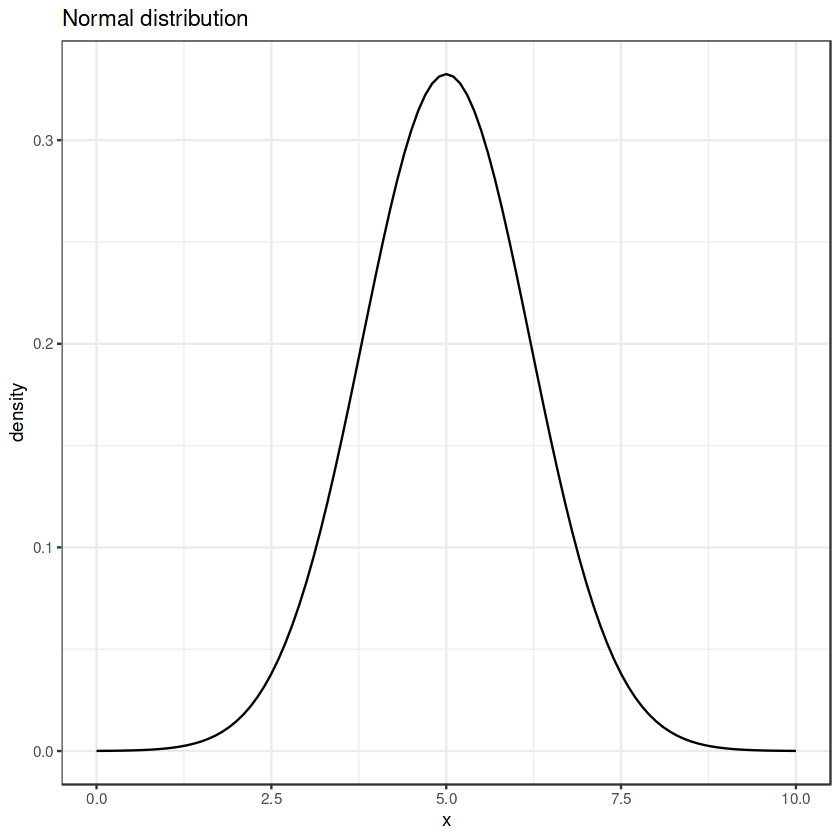

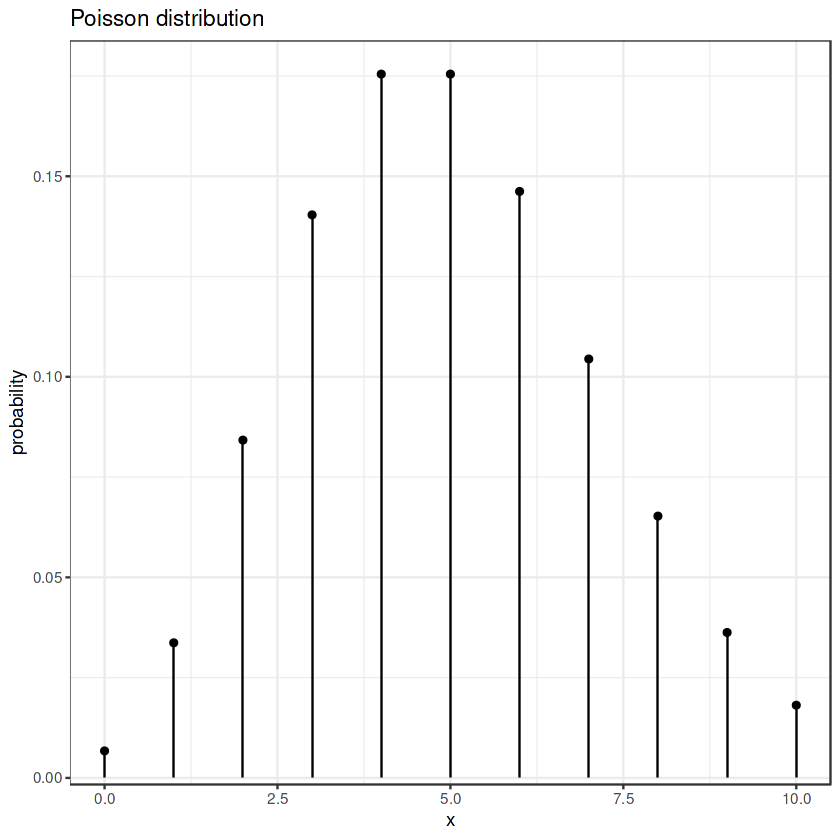

In [8]:
d <- tfd_normal(loc = 5, scale = 1.2)
px <- tfd_prob(d,seq(0,10,by=0.1))

dp <- tfd_poisson(rate = 5)
ppx <- tfd_prob(dp,seq(0,10,by=1))

data.frame(x=seq(0,10,by=0.1),density=as.numeric(px)) %>%
  ggplot(aes(x=x,y=density)) +
  geom_line() +
  ggtitle("Normal distribution") +
  theme_bw()

data.frame(x=seq(0,10,by=1),probability=as.numeric(ppx)) %>%
  ggplot(aes(x=x,y=probability)) +
  geom_point() +
  geom_linerange(aes(ymax=probability), ymin=0) + 
  ggtitle("Poisson distribution") +
  theme_bw()

**Question**: Use TFP to determine the mean and variance of the Poisson distribution from above (with rate=5).
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


.

.

.

.

.

.

.

.

.

Solution:

In [9]:
tfd_mean(dp)
tfd_variance(dp)

tf.Tensor(5.0, shape=(), dtype=float32)

tf.Tensor(5.0, shape=(), dtype=float32)

### Distributions are TensorFlow Objects [advanced. Optional]
The distributions are tensor, so we can use all the magic of TensorFlow ecosystem. For example start with the cdf and take the derivative to get the pdf. You can skip this in the first reading if you like.

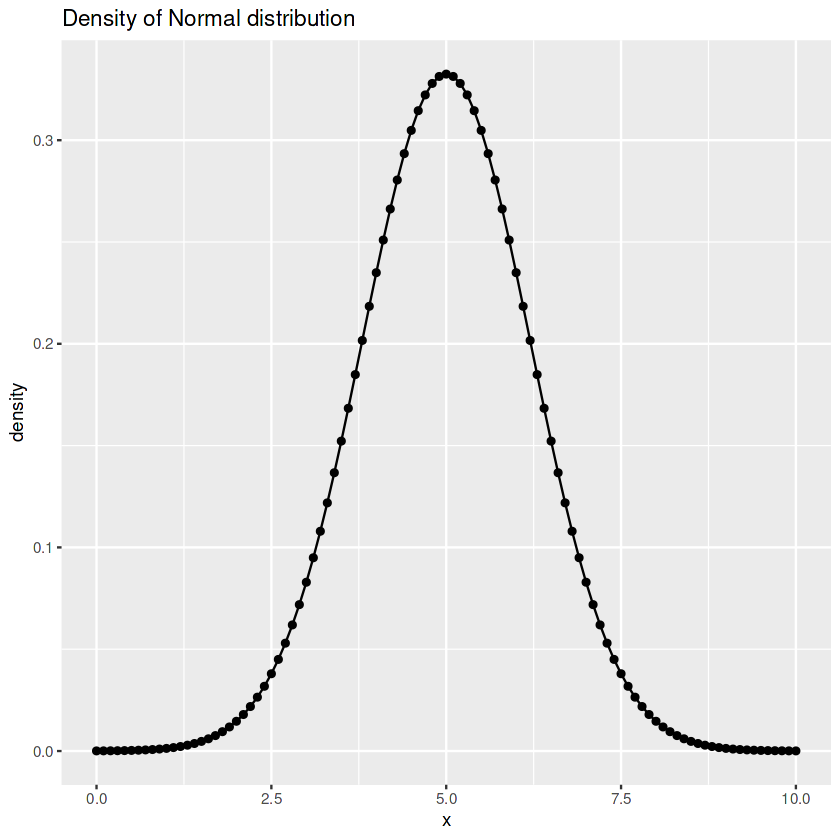

In [10]:
d <- tfd_normal(loc = 5, scale = 1.2)
xs = tf$Variable(seq(0,10,by=0.1), dtype='float32') #We need proper Tensor as x-values
with(tf$GradientTape() %as% t, {
  #In this part of the code stores information (in the tape t) to calculate the gradient
  cdf <- tfd_cdf(d,xs)
})
grads = t$gradient(cdf, xs) #We ask the tape to get gradient of cds w.r.t. xs
xs_vals = xs$numpy() #A working alternative to as.numeric()

data.frame(x=xs_vals,density=as.numeric(grads)) %>%
  ggplot(aes(x=x,y=density)) +
  geom_line() +
  geom_point(data=data.frame(x=xs_vals, y=as.numeric(px)), mapping=aes(x=x,y=y)) +
  ggtitle("Density of Normal distribution") 

In [74]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] tfprobability_0.15.1 tensorflow_2.9.0     keras_2.6.0         
 [4] reticulate_1.26      forcats_0.5.2        stringr_1.4.1       
 [7] dplyr_1.0.10         purrr_0.3.4          readr_2.1.2         
[10] tidyr_1.2.1          tibble_3.1.8         ggp